# **🔭StorySeeker Demo**

This notebook was created by Maria Antoniak as part of the 🔭StorySeeker toolkit. See the [central project Github](https://github.com/maria-antoniak/storyseeker) for more information.

Use this notebook to use the 🔭StorySeeker model to predict whether or not a text contains a story.

If you use our data, codebook, or models, please cite the following paper.

> [Where do people tell stories online? Story Detection Across Online Communities](https://aclanthology.org/2024.acl-long.383/)   
> Maria Antoniak, Joel Mire, Maarten Sap, Elliott Ash, Andrew Piper   
> ACL 2024  


<br><br><br><br>

## **Install and import necessary packages**


In [ ]:
pip install transformers[torch]

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments

In [ ]:
from collections import defaultdict
import gdown
import gzip
import json
import os
import random
import pickle

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

<br><br><br><br>

## **Set parameters and file paths**

This is one of many ways you can load your own dataset. I'm using a dataset of congressional speeches as an example, but you should change this to your own dataset.

Create a folder in your Google Drive and note the location. I like to put all my Colab files in a central directory named ```Colab Output``` but you could use a different location.

Upload your data files to that new folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Update the following two paths to your new folder.

In [ ]:
colab_directory_path = '/content/drive/My Drive/Colab Output/2025-04-congress-storyseeker'

In [ ]:
%cd /content/drive/My Drive/Colab Output/2025-04-congress-storyseeker

/content/drive/My Drive/Colab Output/2025-04-congress-storyseeker


<br><br><br><br>

## **Load StorySeeker model from Hugging Face**

Here I'm loading the StorySeeker model, which is a pretrained RoBERTa model that has been finetuned using our StorySeeker dataset.

I'm also laoding the appropriate tokenizer, which we will need later.

If you get an error when loading the model, make sure your Colab is using a GPU in its runtime.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
device_name = 'cuda'
max_length = 512

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mariaantoniak/storyseeker")
model = AutoModelForSequenceClassification.from_pretrained("mariaantoniak/storyseeker")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
trainer = Trainer(model=model)
trainer.model = model.cuda()

<br><br><br><br>

## **Encode the congressional data and run prediction**

Here I'm loading my example dataset. You should replace this with your own dataset. If your dataset is not a CSV, then you will need to modify this code so that your data is loaded properly.

You don't need any additional metadata, just a set of texts.

In [ ]:
congress_df = pd.read_csv('congress_sample_for_storyseeker.10k.csv')
len(congress_df.index)

10000

In [ ]:
congress_df.sample(3)

,Unnamed: 0,gpo_id,date,congress,chamber,state,member,name,icpsr,party_code,nominate_dim1,nominate_dim2,statement,year,month,year-month,statement_length
6252,296406,171043,1998-06-03,105,house,IN,SOUDER,NaN,NaN,NaN,NaN,NaN,"Speaker, I thank the chairman for yielding me ...",1998,6,1998-06,382
4684,647102,364069,2005-04-26,109,house,GA,GINGREY,"GINGREY, Phil",20319.0,200.0,0.561,0.272,"But, Mr. Speaker, absolutely. What the gentlem...",2005,4,2005-04,227
1731,786065,1238936,2008-01-22,110,senate,KY,MCCONNELL,"McCONNELL, Addison Mitchell (Mitch)",14921.0,200.0,0.403,0.010,"President, with a new year we welcome the newe...",2008,1,2008-01,230


In [ ]:
texts = congress_df['statement'].tolist()

In [ ]:
unique_labels = ['not story', 'story']
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [ ]:
val_encodings  = tokenizer(texts, truncation=True, padding=True, max_length=max_length)

val_labels_encoded  = [0]*len(texts)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
val_dataset = MyDataset(val_encodings, val_labels_encoded)

In [ ]:
predicted_results = trainer.predict(val_dataset)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: maria-antoniak (maria-antoniak-1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<br><br><br><br>

## **Examine the prediction output**

I'm pulling out the labels from the model predictions and saving the results.

In [ ]:
predicted_labels = predicted_results.predictions.argmax(-1)
predicted_labels = predicted_labels.flatten().tolist()
predicted_labels = [id2label[l] for l in predicted_labels]

In [ ]:
len(predicted_labels)

10000

In [ ]:
congress_df['predicted_label'] = predicted_labels

In [ ]:
congress_df.sample(3)

,Unnamed: 0,gpo_id,date,congress,chamber,state,member,name,icpsr,party_code,nominate_dim1,nominate_dim2,statement,year,month,year-month,statement_length,predicted_label
4449,428533,249860,2000-10-10,106,house,MN,OBERSTAR,"OBERSTAR, James Louis",14265.0,100.0,-0.553,0.304,"Mr. Speaker, I just want to repeat the words o...",2000,10,2000-10,401,story
1468,5488,639925,1994-02-24,103,senate,LA,BREAUX,NaN,NaN,NaN,NaN,NaN,"In 1992, the House added a provision to the Oc...",1994,2,1994-02,253,not story
6973,869187,1298216,2009-12-14,111,senate,MN,FRANKEN,"FRANKEN, Al",40904.0,100.0,-0.399,-0.169,May I remind everyone that when the Republican...,2009,12,2009-12,331,not story


In [ ]:
congress_df.to_csv('congress_sample_for_storyseeker.10k.PREDICTED.csv')

### Examine results

In [ ]:
stories = [_text for _predicted_label, _text in zip(predicted_labels, texts) if _predicted_label == 'story']
non_stories = [_text for _predicted_label, _text in zip(predicted_labels, texts) if _predicted_label == 'not story']

In [ ]:
len(stories), len(non_stories)

(900, 9100)

In [ ]:
for _text in random.sample(stories, 50):
    print(' '.join(_text.split()))
    print()

Speaker, I have very fond memories of Floyd Spence. As a freshman on the Committee on Armed Services looking for direction, he was always there as a friend, and he was willing to give counsel. I particularly remember when I asked him to come to Fort Riley in my district to visit the soldiers and see the installation and meet the people. As I visit with people back in the district, they still remember him as being very warm, very committed, very sincere, and a great leader. Mr. Speaker, most people have a birthday every year in their life just to celebrate life, but the one thing that always interested me with Mr. Spence was, the Committee on Armed Services had a birthday to celebrate his lungs because he had been given a special gift as a result of complications he had in his life. My family and I loved him very much. He was always very kind to them. He was willing to give time whenever he could provide it. He was a man who had knew he had been given a great gift from God. He fought fo

In [ ]:
for _text in random.sample(non_stories, 50):
    print(' '.join(_text.split()))
    print()

President, today the Senate considers the nomination of Harold Koh to be Legal Adviser to the Department of State. After reading his answers to dozens of questions, attending his hearing in its entirety, meeting with him privately, and reviewing his writings, I believe that Dean Koh is unquestionably qualified to assume the post for which he is nominated. He has had a distinguished career as a teacher and advocate, and he is regarded widely as one of our Nation's most accomplished experts on the theory and practice of international law. He also has served ably in our government as a Justice Department lawyer during the Reagan administration and as Assistant Secretary of State for Democracy, Human Rights, and Labor from 1998 to 2001. The committee has received innumerable letters of support for the nominee attesting to his character, his love of country, and his respect for the law. He enjoys support from the lawyers with whom he has worked, as well as those including former Solicitor G

<br><br><br><br>

## **Topic model results**

For fun, let's topic model our data and see if there are clear patterns showing that people tell more stories for certain topics.

In [ ]:
!pip install tomotopy

In [ ]:
import tomotopy as tp
import re

In [ ]:
STOPS = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
         'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
         'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
         'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
         'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
         'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
         'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
         'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
         'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
         'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
         'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
         'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 've', 'll', 'amp']


def process_string(text,
                   lowercase=True,
                   remove_short_words=True,
                   remove_stop_words=True,
                   remove_punctuation=True,
                   numbers='replace',
                   urls='remove',
                   stop_words=STOPS,
                   stop_words_extra=[]):
    if lowercase:
        text = text.lower()
    if urls == 'remove':
        text = re.sub(r'http[a-zA-Z://.?0-9-_+#%&$]+', ' ', text)
    if numbers == 'replace':
        text = re.sub('[0-9]+', 'NUM', text)
    elif numbers == 'remove':
        text = re.sub('[0-9]+', ' ', text)
    if remove_punctuation:
        text = re.sub(r'[^\sA-Za-z0-9À-ÖØ-öø-ÿЀ-ӿ/]', ' ', text)
    if remove_stop_words:
        text = ' '.join([word for word in text.split() if word not in stop_words + stop_words_extra])
    if remove_short_words:
        text = ' '.join([word for word in text.split() if not len(word) < 2])
    text = ' '.join(text.split())
    return text

In [ ]:
training_texts = []
training_texts_original = []

for _text in texts:

    _original_text = _text

    _processed_text = process_string(_original_text,
                                     lowercase=True,
                                     urls='remove',
                                     remove_short_words=True,
                                     remove_stop_words=True,
                                     remove_punctuation=True,
                                     numbers='replace',
                                     stop_words=STOPS)

    if len(_processed_text.split()) >= 5 and _processed_text not in training_texts:

        training_texts.append(_processed_text)
        training_texts_original.append(_original_text)

len(training_texts), len(training_texts_original)

(9999, 9999)

In [ ]:
num_topics = 20

mdl = tp.LDAModel(k=num_topics)
for _text in training_texts:
    mdl.add_doc(_text.split())

for i in range(0, 100, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

mdl.summary()

Iteration: 0	Log-likelihood: -9.42107503253203
Iteration: 10	Log-likelihood: -8.938223536046594
Iteration: 20	Log-likelihood: -8.759708094029538
Iteration: 30	Log-likelihood: -8.667951217086616
Iteration: 40	Log-likelihood: -8.608887542679534
Iteration: 50	Log-likelihood: -8.568477698906587
Iteration: 60	Log-likelihood: -8.539039604075613
Iteration: 70	Log-likelihood: -8.513720928141097
Iteration: 80	Log-likelihood: -8.496441957210626
Iteration: 90	Log-likelihood: -8.479545867052583
<Basic Info>
| LDAModel (current version: 0.13.0)
| 9999 docs, 1883102 words
| Total Vocabs: 36849, Used Vocabs: 36849
| Entropy of words: 8.03887
| Entropy of term-weighted words: 8.03887
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 100, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.47955
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words

In [ ]:
full_topic_distributions = []
full_labels = []
full_texts_original = []
full_ids = []

j = 0

for _text, _label in zip(texts, predicted_labels):

    _original_text = _text

    _processed_text = process_string(_original_text,
                                     lowercase=True,
                                     urls='remove',
                                     remove_short_words=True,
                                     remove_stop_words=True,
                                     remove_punctuation=True,
                                     numbers='replace',
                                     stop_words=STOPS)

    if _processed_text.strip():

        _doc_inst = mdl.make_doc(_processed_text.split())
        _dist, ll = mdl.infer(_doc_inst)

        full_labels.append(_label)
        full_texts_original.append(_original_text)
        full_topic_distributions.append(_dist)
        full_ids.append(j)
        j += 1

len(full_texts_original), len(full_labels), len(full_topic_distributions)

(10000, 10000, 10000)

In [ ]:
id_original_text_dict = {_id: _text for _id, _text in zip(full_ids, full_texts_original)}
len(id_original_text_dict)

10000

In [ ]:
id_distribution_dict = {_id: _distribution for _id, _distribution in zip(full_ids, full_topic_distributions)}
len(id_distribution_dict)

10000

In [ ]:
top_words = []
for k in range(mdl.k):
    _word_prob_tuples = mdl.get_topic_words(k, top_n=10)
    print('Topic ' + str(k) + ': ' + ', '.join([w for w, p in _word_prob_tuples]))
    top_words.append(', '.join([w for w, p in _word_prob_tuples]))

Topic 0: amendment, would, bill, vote, rule, legislation, language, could, law, chairman
Topic 1: NUM, military, war, iraq, men, women, troops, forces, defense, world
Topic 2: mr, gentleman, chairman, speaker, bill, time, committee, thank, support, legislation
Topic 3: bill, program, act, department, federal, NUM, national, security, would, funding
Topic 4: NUM, fl, smith, vote, johnson, tx, ca, lewis, oh, davis
Topic 5: people, rights, government, speaker, congress, american, must, today, president, mr
Topic 6: NUM, one, day, people, time, us, year, years, speaker, world
Topic 7: senator, president, senate, bill, would, work, time, floor, think, hope
Topic 8: NUM, veterans, mr, senator, va, service, affairs, senators, kennedy, capitol
Topic 9: NUM, law, court, federal, enforcement, state, justice, drug, crime, states
Topic 10: NUM, budget, billion, year, million, spending, president, percent, cut, security
Topic 11: people, going, think, us, want, get, say, let, one, know
Topic 12: NU

In [ ]:
for k in range(mdl.k):
    print('------------------------------------------------------------------------------')
    print('Topic ' + str(k) + ': ' + top_words[k])
    print('------------------------------------------------------------------------------')
    print()
    _id_prob_tuples = [(_id, _distribution[k]) for _id, _distribution in zip(full_ids, full_topic_distributions)]
    for _id, _prob in sorted(_id_prob_tuples, key=lambda x: x[1], reverse=True)[:5]:
        print(round(_prob, 2), ' '.join(id_original_text_dict[_id].split())[:150] + '...')
        # print()
        # print(' '.join(id_original_text_dict[_id].split()))
    print()

------------------------------------------------------------------------------
Topic 0: amendment, would, bill, vote, rule, legislation, language, could, law, chairman
------------------------------------------------------------------------------

0.58 President, I supported passage of the bill to ban partial birth abortions when it was approved by the Senate on December 7 and I voted last week to ov...
0.57 Speaker, I rise today in support of the Hoyer/ Greenwood/Johnson substitute, the Late Term Abortion Restriction Act, and in opposition to the underlyi...
0.54 This type of approach has been stricken, I believe, in 19 different States as unconstitutional. I offered a substitute which related strictly to late-...
0.54 President, I understand the 60-vote majority, but I have a germane amendment that strikes a provision in the bill. I understand the rules. When someth...
0.52 I rise in opposition to the upcoming amendment submitted by Senator Akaka. The amendment would amend the Truth 

In [ ]:
dicts_to_plot = []
for _id, _text, _label in zip(full_ids, full_texts_original, full_labels):
    _distribution = id_distribution_dict[_id]
    for _topic, _probability in enumerate(_distribution):
        dicts_to_plot.append({'Topic': ' '.join(top_words[_topic].split()[:5]),
                              'Probability': _probability,
                              'Narrative Label': _label})
df_to_plot = pd.DataFrame(dicts_to_plot)

len(df_to_plot.index)

200000

<ipython-input-52-4f640c77b26f>:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.barplot(data=df_to_plot,


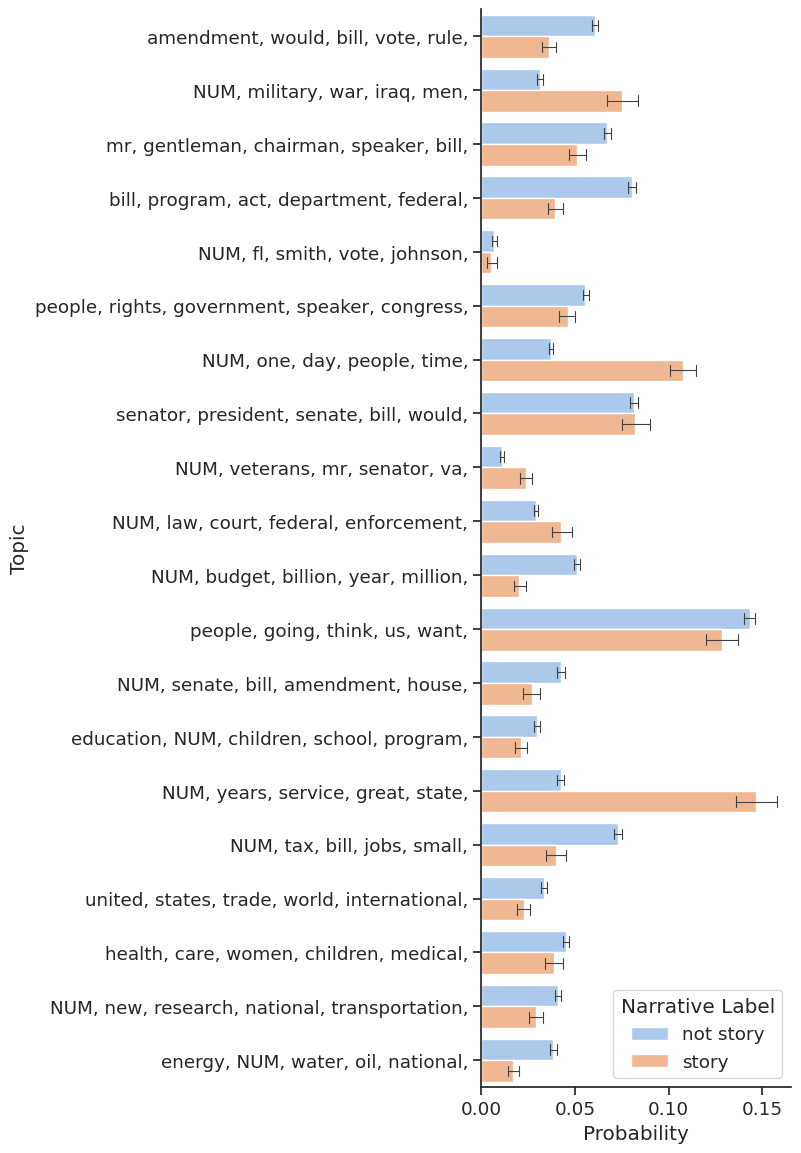

In [ ]:
plt.figure(figsize=(4,14))
sns.barplot(data=df_to_plot,
            x='Probability',
            y='Topic',
            hue='Narrative Label',
            palette='pastel',
            errwidth=0.8,
            capsize=0.4)
sns.despine()

<br><br><br><br>

## **Load StorySeeker annotations from Hugging Face**

You don't need to do this unless you're interested in our annotated data. If you just want to use our model to predict story labels for your own dataset, then use the above cells.

In [ ]:
storyseeker_dataset = load_dataset('mariaantoniak/storyseeker')

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
train_df = pd.DataFrame(storyseeker_dataset['train'])
len(train_df.index)

301

In [ ]:
train_df.sample(3)

,id,type,gold_intersection,gold_union,gold_consensus,maria_span,joel_span,split
5,clvvas8,comment,0,0,0,0,0,train
115,ccso8hp,comment,1,1,1,1,1,train
165,cq8us4r,comment,1,1,1,1,1,train


In [ ]:
val_df = pd.DataFrame(storyseeker_dataset['val'])
len(val_df.index)

100

In [ ]:
val_df.sample(3)

,id,type,gold_intersection,gold_union,gold_consensus,maria_span,joel_span,split
1,t3_2xl08s,post,0,0,0,0,0,val
22,crgepve,comment,1,1,1,1,1,val
38,t3_1g3j09,post,1,1,1,1,1,val


<br><br><br><br>

## **Load Reddit data**

Again, you don't need to do this unless you are interested in the data we annotated as part of our paper, which was used to finetune the model. If you just want to use our model to predict story labels for your own dataset, then use the above cells.

We don't provide exact copies of the Reddit dataset and instead provide IDs that link back to the original Reddit dataset. The code in this section will show you how to "rehydrate" our annotated data.

"The Webis TLDR Corpus (2017) consists of approximately 4 Million content-summary pairs extracted for Abstractive Summarization, from the Reddit dataset for the years 2006-2016. This corpus is first of its kind from the social media domain in English and has been created to compensate the lack of variety in the datasets used for abstractive summarization research using deep learning models."

Read more here: [https://webis.de/data/webis-tldr-17.html](https://webis.de/data/webis-tldr-17.html)

From:
Michael Völske, Martin Potthast, Shahbaz Syed, and Benno Stein. [TL;DR: Mining Reddit to Learn Automatic Summarization](https://downloads.webis.de/publications/papers/voelske_2017.pdf). In Giuseppe Carenini, Jackie Chi Kit Cheung, Fei Liu, and Lu Wang, editors, Workshop on New Frontiers in Summarization at EMNLP 2017, pages 59–63, September 2017. Association for Computational Linguistics.

In [ ]:
reddit_path = 'https://zenodo.org/records/1043504/files/corpus-webis-tldr-17.zip?download=1'

In [ ]:
import urllib.request
import json
from io import BytesIO
from zipfile import ZipFile

In [ ]:
target_ids = train_df['id'].tolist() + val_df['id'].tolist()

In [ ]:
access_url = urllib.request.urlopen(reddit_path)

id_data_dict = {}
with ZipFile(BytesIO(access_url.read()), 'r') as zip_obj:
  for _filename in zip_obj.namelist():
    with zip_obj.open(_filename) as _file:
      for _line in _file:
        _data = json.loads(_line)
        if _data['id'] in target_ids:
          for _key, _value in _data.items():
            id_data_dict[_data['id']] = _data
len(id_data_dict)

400

In [ ]:
len(id_data_dict)

400

In [ ]:
random.sample(id_data_dict.items(), 1)

<ipython-input-43-33d35bd641a0>:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(id_data_dict.items(), 1)


[('c3q5abb',
  {'author': 'phishsticker',
   'body': "With Downing and Kuyt on the field, we lack that cutting edge. Downing is basically invisible most of the game, and Kuyt really lacks the pace and skill to work on the right side. Our attack is so easily defended against that its laughable. We need a skillful RW/LW that can actually beat their player and whip a GOOD ball in or take a 1/2 decent shot. \n\nCarroll was back to his usual self, he really seems to hate coming on as a sub. You could hear Kenny on the side constantly yelling at him to apply some pressure. \n\nBoth goals were through individual mistakes and were avoidable, but we didn't deserve anything from the match. We were atrocious for 90% of the game. I really think we will regret not bringing in a striker or rw in january, I have no idea where our goals will come from unless Bellamy magically wakes up with working knees. Oh and Evra is a cunt.\n\n**tldr: we were shit, evra is a cunt**",
   'normalizedBody': "With Down

In [ ]:
train_df['text'] = train_df['id'].apply(lambda x: id_data_dict[x]['body'])
val_df['text'] = val_df['id'].apply(lambda x: id_data_dict[x]['body'])

In [ ]:
train_df.sample(3)

,id,type,gold_intersection,gold_union,gold_consensus,maria_span,joel_span,split,text
165,cq8us4r,comment,1,1,1,1,1,train,I know you jest; but PSA: Horses can be danger...
205,c1sgi4c,comment,0,0,0,0,0,train,For me its because it distills everything Han ...
231,c6n6avv,comment,0,1,0,0,1,train,So I did some digging and the long and the sho...


In [ ]:
X_train = train_df['text'].tolist()
X_val = val_df['text'].tolist()

# y_train = _story_df_train['gold_intersection'].tolist()
# y_val = _story_df_test['gold_intersection'].tolist()
y_train = train_df['gold_consensus'].tolist()
y_val = val_df['gold_consensus'].tolist()

len(X_train), len(X_val), len(y_train), len(y_val)

(301, 100, 301, 100)

We recommend using the ```gold_consensus``` labels as these are the highest quality annotations, representing the most discussion and deliberation by the annotators.